Epoch: 100 cost = 1.174895
Epoch: 200 cost = 0.193910
Epoch: 300 cost = 0.055387
Epoch: 400 cost = 0.027604
Epoch: 500 cost = 0.016837
ich mochte ein bier P -> ['i', 'want', 'a', 'a', 'E']


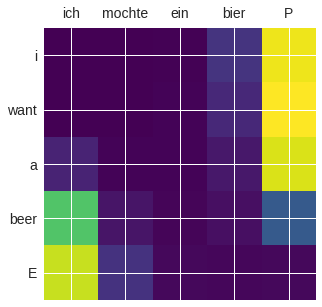


sie liebt ein bier P -> ['she', 'love', 'a', 'beer', 'E']


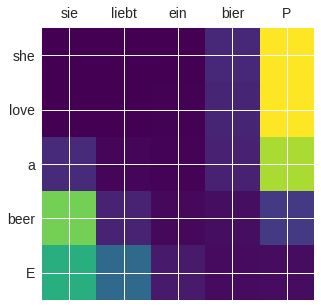


bier ist eine liebe P -> ['beer', 'a', 'a', 'a', 'E']


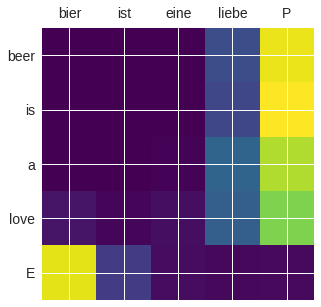

In [0]:
# code by Minho Ryu @bzantium
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/seq2seq_models.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import FloatTensor as FT
from torch import LongTensor as LT

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = [['ich mochte ein bier P', 'S i want a beer', 'i want a beer E'], 
             ['sie liebt ein bier P', 'S she love a beer', 'she love a beer E'],
             ['bier ist eine liebe P', 'S beer is a love', 'beer is a love E']]

word_list = " ".join(sentences[0] + sentences[1] + sentences[2]).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}

# Parameter
vocab_size = len(word_dict)
n_embed = 5
n_step = 5  # maxium number of words in one sentence(=number of time steps)
n_hidden = 32
n_class = len(word_dict)  # vocab list

def make_batch(sentences):
    input_batch, output_batch, target_batch = [], [], []
    for sentence in sentences:
        input_batch.append([word_dict[n] for n in sentence[0].split()])
        output_batch.append([word_dict[n] for n in sentence[1].split()])
        target_batch.append([word_dict[n] for n in sentence[2].split()])
    
    return LT(input_batch), LT(output_batch), LT(target_batch)

class seq2seq_attn(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, n_class):
        super(seq2seq_attn, self).__init__()
        self.vocab_size = vocab_size
        self.n_embed = n_embed
        self.n_class = n_class
        self.n_hidden = n_hidden
        self.enc_lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hidden)
        self.dec_lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hidden)
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_input, dec_input):
        enc_input = self.embedding(enc_input).transpose(0, 1) # enc_input: [n_step, batch_size, n_embed]
        dec_input = self.embedding(dec_input).transpose(0, 1) # dec_input: [n_step, batch_size, n_embed]

        enc_outputs, enc_hidden = self.enc_lstm(enc_input) # enc_outputs: [n_step, batch_size, n_hidden], # enc_hidden: (h: [1, batch_size, n_hidden], c: [1, batch_size, n_hidden])
        trained_attn = []
        hidden = enc_hidden
        n_step, batch_size, _ = dec_input.size()
        logits = torch.empty([n_step, batch_size, self.n_class])

        for i in range(n_step):  # each time step
            dec_output, hidden = self.dec_lstm(dec_input[i].unsqueeze(0), hidden) # dec_inputs[i].unsqueeze(0): [1, batch_size, n_embed], dec_output: [1, batch_size, hidden]
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [batch_size, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            context = attn_weights.matmul(enc_outputs.transpose(0, 1)).squeeze(1) # [batch_size, n_hidden]
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size, hidden]
            logits[i] = self.out(torch.cat((dec_output, context), 1)) # [batch_size, n_class]

        # make model shape [n_step, n_class]
        return logits.transpose(0, 1).transpose(1, 2), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # dec_output: [1, batch_size, n_hidden], enc_outputs: [n_step, batch_size, n_hidden]
        n_step, batch_size, _ = enc_outputs.size()
        attn_scores = torch.zeros(batch_size, n_step) # [batch_size, n_step]

        for i in range(n_step):
            attn_scores[:,i] = self.get_att_score(dec_output, enc_outputs[i]) # attn_scores[:, i]: [batch_size]

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores, -1).view(batch_size, 1, n_step)

    def get_att_score(self, dec_output, enc_output):  # enc_output: [batch_size, n_hidden]
        enc_output = enc_output.unsqueeze(2)  # enc_output: [batch_size, n_hidden, 1]
        dec_output = dec_output.transpose(0, 1) # [batch_size, 1, n_hidden]
        score = torch.matmul(dec_output, enc_output) / torch.sqrt(FT(self.n_hidden))
        return torch.matmul(dec_output, enc_output).squeeze() # [batch_size]

input_batch, output_batch, target_batch = make_batch(sentences)

model = seq2seq_attn(vocab_size, n_embed, n_hidden, n_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(500):
    optimizer.zero_grad()
    output, _ = model(input_batch, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%03d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()


# Show Attention
for sentence in sentences:
    input_batch, _, _ = make_batch([sentence])
    predict_batch = LT([[word_dict[n] for n in 'P P P P P'.split()]])

    predict, attention = model(input_batch, predict_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    
    print(sentence[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + sentence[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentence[2].split(), fontdict={'fontsize': 14})
    plt.show()
    print()